In [1]:
import os
import torch
import torch.nn as nn


from config import get_config
from data.loader import get_dataloaders
from models.model import create_model
from train_utils.resume import init_resume_state
from train_utils.train_epoch import train_one_epoch
from train_utils.evaluate import evaluate
from train_utils.train_metrics_logger import update_train_logs
from train_utils.train_metrics_logger import update_val_logs
from train_utils.checkpoint_saver import save_epoch_checkpoint
from train_utils.train_metrics_logger import record_and_save_epoch
from train_utils.early_stopping import check_early_stopping
from train_utils.training_summary import finalize_training_summary
from train_utils.training_summary import print_best_model_summary
from train_utils.plot_metrics import plot_train_val_metrics
from train_utils.plot_metrics import plot_loss_accuracy


In [ ]:
# cfg=get_config(config_path="config/convnext_bs512_ep50_lr1e-04_ds1000.yml")
cfg=get_config()
print(cfg)

[INFO] Config Path: config/convnext_bs512_ep50_lr1e-04_ds1000.yml
[INFO] Detected WSL environment
[INFO] Using dataset root: /mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled
[INFO] Detected dataset size: 1000
namespace(model_tag='ConvNeXt', backbone='convnext', batch_size=512, epochs=50, learning_rate=0.0001, patience=5, input_shape=(1, 32, 32), global_max=121.79151153564453, dataset_root_dir='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled', train_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_balanced_unshuffled/train_files.csv', val_csv='/mnt/d/Projects/110_JetscapeML/hm_jetscapeml_source/data/jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_

In [3]:
os.makedirs(cfg.output_dir, exist_ok=True)
print(f"[INFO] Saving all outputs to: {cfg.output_dir}")

[INFO] Saving all outputs to: training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000


In [4]:
# Set seed, device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Using device: {device}")
# torch.backends.cudnn.benchmark = True

[INFO] Using device: cuda


In [5]:
# Data
train_loader, val_loader, test_loader = get_dataloaders(cfg)

[INFO] Training samples: 796
[INFO] Validation samples: 96
[INFO] Test samples: 108
[INFO] Length of training dataloader: 2
[INFO] Length of validation dataloader: 1
[INFO] Length of test dataloader: 1


In [6]:
# Model and optimizer
model, optimizer = create_model(cfg.backbone, cfg.input_shape, cfg.learning_rate)
model.to(device)

[INFO] Using ConvNeXt backbone with input shape: (1, 32, 32)
[INFO] ConvNeXt backbone initialized with input shape: (1, 32, 32)


MultiHeadClassifier(
  (backbone): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): Mlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (norm): Identity()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): ConvNeXtBlock(
            (conv

In [7]:
criterion = {
    # 'energy_loss_output': nn.BCELoss(),
    'energy_loss_output': nn.BCEWithLogitsLoss(),
    'alpha_output': nn.CrossEntropyLoss(),
    'q0_output': nn.CrossEntropyLoss()
}
print(f"[INFO] Loss functions:{criterion}")

[INFO] Loss functions:{'energy_loss_output': BCEWithLogitsLoss(), 'alpha_output': CrossEntropyLoss(), 'q0_output': CrossEntropyLoss()}


In [8]:
print(f"[INFO] Init Training Trackers")
train_loss_energy_list, train_loss_alpha_list, train_loss_q0_list, train_loss_list = [], [], [],[]
train_acc_energy_list, train_acc_alpha_list, train_acc_q0_list, train_acc_list = [], [], [], []

print(f"[INFO] Init Validation Trackers")
val_loss_energy_list, val_loss_alpha_list,val_loss_q0_list,val_loss_list = [], [], [], []
val_acc_energy_list, val_acc_alpha_list,val_acc_q0_list ,val_acc_list = [],[],[],[]

[INFO] Init Training Trackers
[INFO] Init Validation Trackers


In [9]:
model, optimizer, start_epoch, best_acc, early_stop_counter, best_epoch, best_metrics, training_summary, all_epoch_metrics = init_resume_state( model, optimizer, device,cfg)

[INFO] Init Resume/Training Parameters
[INFO] Starting fresh training run by initializing training summary
[INFO] 📄 Training summary saved to: training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/training_summary.json


In [10]:
train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
print(f"[INFO] Training metrics: {train_metrics}")

[INFO] Training metrics: {'loss': 3.7159266471862793, 'loss_energy': 0.6698406934738159, 'loss_alpha': 1.4636253714561462, 'loss_q0': 1.5824605226516724, 'accuracy': 0.05025125628140704, 'accuracy_energy': 0.5188442211055276, 'accuracy_alpha': 0.33040201005025127, 'accuracy_q0': 0.2675879396984925}


In [11]:
for epoch in range(start_epoch, cfg.epochs):
    print(f"[INFO] Epoch {epoch+1}/{cfg.epochs}")
    train_metrics={}
    train_metrics = train_one_epoch(train_loader, model, criterion, optimizer, device)
    (train_loss_list,
    train_loss_energy_list,
    train_loss_alpha_list,
    train_loss_q0_list,
    train_acc_list,
    train_acc_energy_list,
    train_acc_alpha_list,
    train_acc_q0_list
    ) = update_train_logs(
        train_metrics,
        train_loss_list,
        train_loss_energy_list,
        train_loss_alpha_list,
        train_loss_q0_list,
        train_acc_list,
        train_acc_energy_list,
        train_acc_alpha_list,
        train_acc_q0_list
    )
    val_metrics = evaluate(val_loader, model, criterion, device)
    (val_loss_list,
    val_loss_energy_list,
    val_loss_alpha_list,
    val_loss_q0_list,
    val_acc_list,
    val_acc_energy_list,
    val_acc_alpha_list,
    val_acc_q0_list,
    ) = update_val_logs(
        val_metrics,
        val_loss_list,
        val_loss_energy_list,
        val_loss_alpha_list,
        val_loss_q0_list,
        val_acc_list,
        val_acc_energy_list,
        val_acc_alpha_list,
        val_acc_q0_list,
    )
    print(f"[INFO] Epoch {epoch+1}: Energy Acc ={val_metrics['energy']['accuracy']:.4f}, αs Acc = {val_metrics['alpha']['accuracy']:.4f}, Q0 Acc = {val_metrics['q0']['accuracy']:.4f}, Total Acc = {val_metrics['accuracy']:.4f}")
    print(f"[INFO] Epoch {epoch+1}: Energy Loss ={val_metrics['loss_energy']:.4f}, αs Loss = {val_metrics['loss_alpha']:.4f}, Q0 Loss = {val_metrics['loss_q0']:.4f}, Total Loss = {val_metrics['loss']:.4f}")
    
    all_epoch_metrics=record_and_save_epoch(epoch, train_metrics, val_metrics, all_epoch_metrics, cfg.output_dir)
    
    # save_epoch_checkpoint(
    #     epoch=epoch,
    #     model=model,
    #     optimizer=optimizer,
    #     metrics=val_metrics,
    #     output_dir=cfg.output_dir
    # )

    best_acc, best_metrics, best_epoch, early_stop_counter, should_stop = check_early_stopping(
        best_acc=best_acc,
        best_metrics=best_metrics,
        early_stop_counter=early_stop_counter,
        best_epoch=best_epoch,
        model=model,
        optimizer=optimizer,
        val_metrics=val_metrics,
        output_dir=cfg.output_dir,
        patience=cfg.patience,
        epoch=epoch
    )
    
    if should_stop:
        break
    
    print("="*150)
    

[INFO] Epoch 1/50


[INFO] Epoch 1: Energy Acc =0.7396, αs Acc = 0.3333, Q0 Acc = 0.2292, Total Acc = 0.0729
[INFO] Epoch 1: Energy Loss =0.6118, αs Loss = 1.3980, Q0 Loss = 1.5426, Total Loss = 3.5524
[INFO] Epoch 1: Saving metrics to disk
✅ Best model saved at epoch 1 with total accuracy: 0.0729
[INFO] Epoch 2/50


[INFO] Epoch 2: Energy Acc =0.7292, αs Acc = 0.3438, Q0 Acc = 0.2188, Total Acc = 0.0729
[INFO] Epoch 2: Energy Loss =0.6199, αs Loss = 1.0935, Q0 Loss = 1.4402, Total Loss = 3.1535
[INFO] Epoch 2: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/5
[INFO] Epoch 3/50


[INFO] Epoch 3: Energy Acc =0.7500, αs Acc = 0.3333, Q0 Acc = 0.2500, Total Acc = 0.0938
[INFO] Epoch 3: Energy Loss =0.5703, αs Loss = 1.1707, Q0 Loss = 1.4386, Total Loss = 3.1796
[INFO] Epoch 3: Saving metrics to disk
✅ Best model saved at epoch 3 with total accuracy: 0.0938
[INFO] Epoch 4/50


[INFO] Epoch 4: Energy Acc =0.7500, αs Acc = 0.3542, Q0 Acc = 0.2500, Total Acc = 0.0938
[INFO] Epoch 4: Energy Loss =0.6428, αs Loss = 1.0991, Q0 Loss = 1.4836, Total Loss = 3.2255
[INFO] Epoch 4: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/5
[INFO] Epoch 5/50


[INFO] Epoch 5: Energy Acc =0.7500, αs Acc = 0.4167, Q0 Acc = 0.2500, Total Acc = 0.0938
[INFO] Epoch 5: Energy Loss =0.6413, αs Loss = 1.0769, Q0 Loss = 1.4055, Total Loss = 3.1237
[INFO] Epoch 5: Saving metrics to disk
⏳ No improvement. Early stop counter: 2/5
[INFO] Epoch 6/50


[INFO] Epoch 6: Energy Acc =0.7500, αs Acc = 0.3854, Q0 Acc = 0.2292, Total Acc = 0.1042
[INFO] Epoch 6: Energy Loss =0.5751, αs Loss = 1.0797, Q0 Loss = 1.4218, Total Loss = 3.0766
[INFO] Epoch 6: Saving metrics to disk
✅ Best model saved at epoch 6 with total accuracy: 0.1042
[INFO] Epoch 7/50


[INFO] Epoch 7: Energy Acc =0.7500, αs Acc = 0.3854, Q0 Acc = 0.2292, Total Acc = 0.0938
[INFO] Epoch 7: Energy Loss =0.5908, αs Loss = 1.0730, Q0 Loss = 1.4219, Total Loss = 3.0857
[INFO] Epoch 7: Saving metrics to disk
⏳ No improvement. Early stop counter: 1/5
[INFO] Epoch 8/50


[INFO] Epoch 8: Energy Acc =0.7188, αs Acc = 0.4479, Q0 Acc = 0.1875, Total Acc = 0.0729
[INFO] Epoch 8: Energy Loss =0.6283, αs Loss = 1.0683, Q0 Loss = 1.4089, Total Loss = 3.1055
[INFO] Epoch 8: Saving metrics to disk
⏳ No improvement. Early stop counter: 2/5
[INFO] Epoch 9/50


[INFO] Epoch 9: Energy Acc =0.7500, αs Acc = 0.4271, Q0 Acc = 0.2188, Total Acc = 0.0833
[INFO] Epoch 9: Energy Loss =0.5763, αs Loss = 1.0694, Q0 Loss = 1.4109, Total Loss = 3.0566
[INFO] Epoch 9: Saving metrics to disk
⏳ No improvement. Early stop counter: 3/5
[INFO] Epoch 10/50


[INFO] Epoch 10: Energy Acc =0.7500, αs Acc = 0.4375, Q0 Acc = 0.2292, Total Acc = 0.0938
[INFO] Epoch 10: Energy Loss =0.5740, αs Loss = 1.0644, Q0 Loss = 1.4124, Total Loss = 3.0508
[INFO] Epoch 10: Saving metrics to disk
⏳ No improvement. Early stop counter: 4/5
[INFO] Epoch 11/50


[INFO] Epoch 11: Energy Acc =0.7500, αs Acc = 0.4167, Q0 Acc = 0.2083, Total Acc = 0.0833
[INFO] Epoch 11: Energy Loss =0.5964, αs Loss = 1.0683, Q0 Loss = 1.4138, Total Loss = 3.0785
[INFO] Epoch 11: Saving metrics to disk
⏳ No improvement. Early stop counter: 5/5
🛑 Early stopping triggered at epoch 11. Best was at epoch 6.


In [12]:
finalize_training_summary(
    summary=training_summary,
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics,
    output_dir=cfg.output_dir
)
print_best_model_summary(
    best_epoch=best_epoch,
    best_acc=best_acc,
    best_metrics=best_metrics
)

[INFO] 📄 Training summary saved to: training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/training_summary.json

🏁 Best Model @ Epoch 6
Total Accuracy: 0.1042

🔹 ENERGY Task
  Accuracy : 0.7500
  Precision: 0.3750
  Recall   : 0.5000
  F1-Score : 0.4286

🔹 ALPHA Task
  Accuracy : 0.3854
  Precision: 0.3598
  Recall   : 0.3854
  F1-Score : 0.3311

🔹 Q0 Task
  Accuracy : 0.2292
  Precision: 0.1458
  Recall   : 0.2292
  F1-Score : 0.1616


📊 Plots saved to:
 - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/loss_accuracy_plot.png
 - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/loss_accuracy_plot.pdf


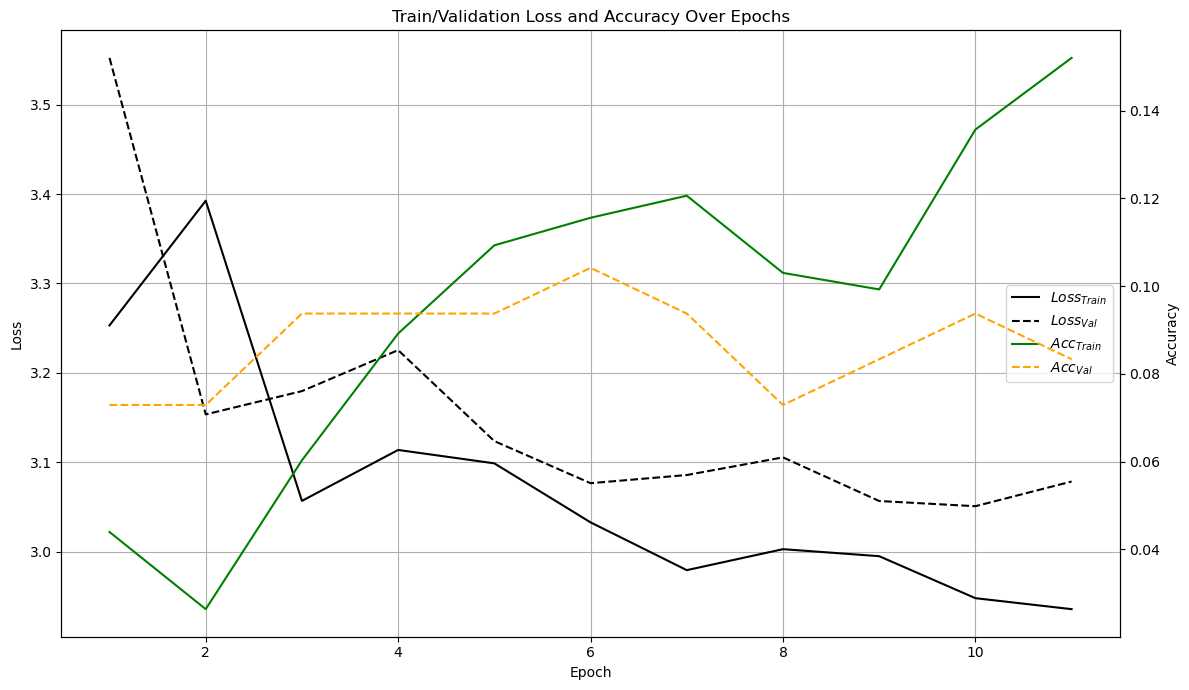

📉 Loss plot saved as:
  - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/train_loss_and_accuracy_per_epoch_plot.png
  - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/train_loss_and_accuracy_per_epoch_plot.pdf


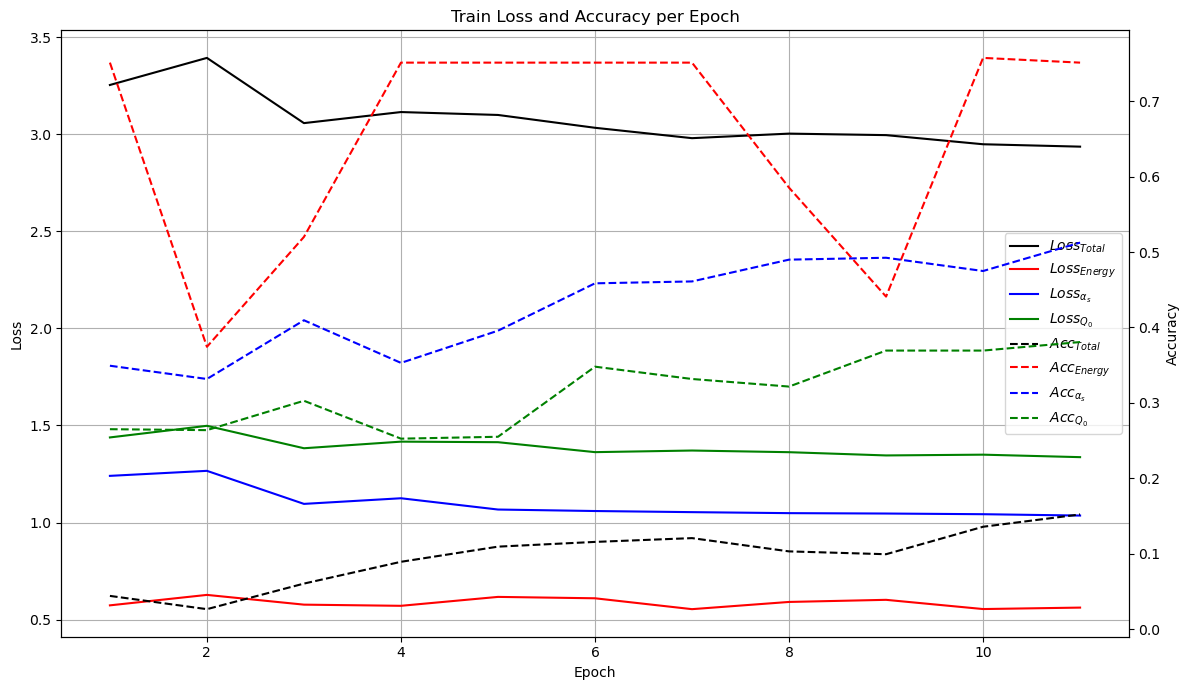

📉 Loss plot saved as:
  - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/validation_loss_and_accuracy_per_epoch_plot.png
  - training_output/ConvNeXt_bs512_ep50_lr1e-04_ds1000/validation_loss_and_accuracy_per_epoch_plot.pdf


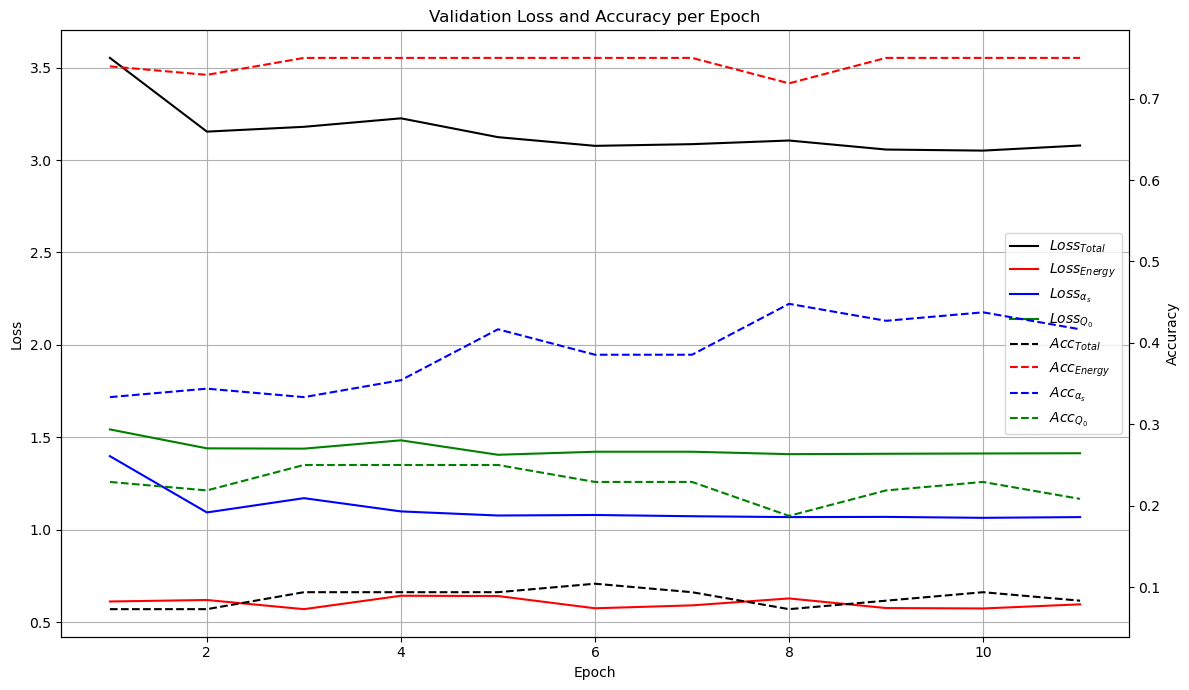

In [13]:
plot_train_val_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list, cfg.output_dir)
plot_loss_accuracy(train_loss_list,
                    train_loss_energy_list,
                    train_loss_alpha_list,
                    train_loss_q0_list,
                    train_acc_list,
                    train_acc_energy_list,
                    train_acc_alpha_list,
                    train_acc_q0_list,
                    cfg.output_dir,
                    title="Train Loss and Accuracy per Epoch")
plot_loss_accuracy(val_loss_list,
                    val_loss_energy_list,
                    val_loss_alpha_list,
                    val_loss_q0_list,
                    val_acc_list,
                    val_acc_energy_list,
                    val_acc_alpha_list,
                    val_acc_q0_list,
                    cfg.output_dir,
                    title="Validation Loss and Accuracy per Epoch")